In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
wandb.init(project="enefit_prediction_consumer")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [6]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn_lstm.weights.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [10]:
class CNNEncoding:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.features = None
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = Conv1D(32, 3, activation='selu')(inputs)
        x = MaxPooling1D(2)(x)
        x = Flatten()(x)
        x = Dense(1024, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(512, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(256, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(64, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        self.features = Dense(32, activation='selu')(x)
        x=BatchNormalization()(self.features)
        x=Dropout(0.5)(x)
        
        output = Dense(1, activation='linear')(x)
        
        model = Model(inputs, output, name='model1')
        return model
input_shape=(len(X.columns),1)
cnn_model=CNNEncoding(input_shape=input_shape)
cnn_model.model.load_weights('weights/cnn.hdf5')
cnn_model.model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1639424   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                             

In [11]:
class LSTMClassification:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = LSTM(units=50)(inputs)  # Adjust units and other parameters as needed
        x = Dropout(0.4)(x)
        x = Dense(units=50, activation='selu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(units=1, activation='linear')(x)
        model = Model(inputs, outputs, name='model2')
        return model
input_dim=(32,1)
lstm_classification = LSTMClassification(input_shape=input_dim)
lstm_classification.model.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13001 (50.79 KB)
Trainable params: 13001 (50.7

In [12]:
# lstm_classification.model.load_weights('weights/lstm.hdf5')


In [13]:
class CNN_LSTM:
    def __init__(self, input_shape,encoder, classification, lr=0.0001):
        self.input_shape = input_shape
        self.model1 = encoder.model
        self.feature_shape = (encoder.features.shape[1],)
        self.features=encoder.features
        self.model2 = classification.model
        self.lr = lr
        self.model = self.build_model()
        
    def build_model(self):
        combined_input = self.model1.input
        output = self.model2(self.features)
        combined_model = Model(inputs=combined_input, outputs=output, name='combined_model')
        combined_model.compile(optimizer=Adam(learning_rate=self.lr), loss='mae', metrics=['mae', r2])
        return combined_model

In [14]:
model =CNN_LSTM(input_shape=input_shape,encoder=cnn_model, classification=lstm_classification).model
model.summary()


Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1639424   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                     

In [15]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(metric_aliases={'mae': 'mean_absolute_error','r2':'r2','val_mae':'val_mean_absolute_error', 'val_r2':'val_r2'}),early_stopping,lr_scheduler,checkpoint_callback])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1342 - mae: 0.1342 - r2: 0.6247INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 1: val_loss improved from inf to 0.09907, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 496s 29ms/step - loss: 0.1342 - mae: 0.1342 - r2: 0.6248 - val_loss: 0.0991 - val_mae: 0.0991 - val_r2: 0.8803 - lr: 1.0000e-04
Epoch 2/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1105 - mae: 0.1105 - r2: 0.7167
Epoch 2: val_loss did not improve from 0.09907
16982/16982 [==============================] - 516s 30ms/step - loss: 0.1105 - mae: 0.1105 - r2: 0.7167 - val_loss: 0.1023 - val_mae: 0.1023 - val_r2: 0.8754 - lr: 1.0000e-04
Epoch 3/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1062 - mae: 0.1062 - r2: 0.7540INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 3: val_loss improved from 0.09907 to 0.09152, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 516s 30ms/step - loss: 0.1062 - mae: 0.1062 - r2: 0.7540 - val_loss: 0.0915 - val_mae: 0.0915 - val_r2: 0.9024 - lr: 1.0000e-04
Epoch 4/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1042 - mae: 0.1042 - r2: 0.7572
Epoch 4: val_loss did not improve from 0.09152
16982/16982 [==============================] - 527s 31ms/step - loss: 0.1042 - mae: 0.1042 - r2: 0.7572 - val_loss: 0.1013 - val_mae: 0.1013 - val_r2: 0.8750 - lr: 1.0000e-04
Epoch 5/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1024 - mae: 0.1024 - r2: 0.7712
Epoch 5: val_loss did not improve from 0.09152
16982/16982 [==============================] - 533s 31ms/step - loss: 0.1024 - mae: 0.1024 - r2: 0.7712 - val_loss: 0.1041 - val_mae: 0.1041 - val_r2: 0.8621 - lr: 1.0000e-04
Epoch 6/10000
16982/16982 [==============================] 

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 9: val_loss improved from 0.09152 to 0.09054, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 512s 30ms/step - loss: 0.0974 - mae: 0.0974 - r2: 0.7997 - val_loss: 0.0905 - val_mae: 0.0905 - val_r2: 0.9091 - lr: 1.0000e-04
Epoch 10/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0966 - mae: 0.0966 - r2: 0.8035
Epoch 10: val_loss did not improve from 0.09054
16982/16982 [==============================] - 515s 30ms/step - loss: 0.0966 - mae: 0.0966 - r2: 0.8034 - val_loss: 0.1044 - val_mae: 0.1044 - val_r2: 0.8474 - lr: 1.0000e-04
Epoch 11/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0951 - mae: 0.0951 - r2: 0.8124INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 11: val_loss improved from 0.09054 to 0.08772, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 520s 31ms/step - loss: 0.0951 - mae: 0.0951 - r2: 0.8124 - val_loss: 0.0877 - val_mae: 0.0877 - val_r2: 0.9147 - lr: 1.0000e-04
Epoch 12/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0944 - mae: 0.0944 - r2: 0.8047
Epoch 12: val_loss did not improve from 0.08772
16982/16982 [==============================] - 541s 32ms/step - loss: 0.0944 - mae: 0.0944 - r2: 0.8047 - val_loss: 0.0911 - val_mae: 0.0911 - val_r2: 0.8988 - lr: 1.0000e-04
Epoch 13/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0937 - mae: 0.0937 - r2: 0.8149
Epoch 13: val_loss did not improve from 0.08772
16982/16982 [==============================] - 542s 32ms/step - loss: 0.0937 - mae: 0.0937 - r2: 0.8149 - val_loss: 0.0959 - val_mae: 0.0959 - val_r2: 0.8664 - lr: 1.0000e-04
Epoch 14/10000
16981/16982 [==========================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 14: val_loss improved from 0.08772 to 0.08616, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 551s 32ms/step - loss: 0.0926 - mae: 0.0926 - r2: 0.8207 - val_loss: 0.0862 - val_mae: 0.0862 - val_r2: 0.9114 - lr: 1.0000e-04
Epoch 15/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0920 - mae: 0.0920 - r2: 0.8239INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 15: val_loss improved from 0.08616 to 0.08354, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 556s 33ms/step - loss: 0.0920 - mae: 0.0920 - r2: 0.8239 - val_loss: 0.0835 - val_mae: 0.0835 - val_r2: 0.9116 - lr: 1.0000e-04
Epoch 16/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0912 - mae: 0.0912 - r2: 0.8225
Epoch 16: val_loss did not improve from 0.08354
16982/16982 [==============================] - 560s 33ms/step - loss: 0.0912 - mae: 0.0912 - r2: 0.8225 - val_loss: 0.0906 - val_mae: 0.0906 - val_r2: 0.8890 - lr: 1.0000e-04
Epoch 17/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0905 - mae: 0.0905 - r2: 0.8331INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 17: val_loss improved from 0.08354 to 0.08320, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 566s 33ms/step - loss: 0.0905 - mae: 0.0905 - r2: 0.8331 - val_loss: 0.0832 - val_mae: 0.0832 - val_r2: 0.9207 - lr: 1.0000e-04
Epoch 18/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0896 - mae: 0.0896 - r2: 0.8342INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 18: val_loss improved from 0.08320 to 0.08042, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 600s 35ms/step - loss: 0.0896 - mae: 0.0896 - r2: 0.8342 - val_loss: 0.0804 - val_mae: 0.0804 - val_r2: 0.9232 - lr: 1.0000e-04
Epoch 19/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0894 - mae: 0.0894 - r2: 0.8340
Epoch 19: val_loss did not improve from 0.08042
16982/16982 [==============================] - 585s 34ms/step - loss: 0.0894 - mae: 0.0894 - r2: 0.8340 - val_loss: 0.0857 - val_mae: 0.0857 - val_r2: 0.9153 - lr: 1.0000e-04
Epoch 20/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0889 - mae: 0.0889 - r2: 0.8365
Epoch 20: val_loss did not improve from 0.08042
16982/16982 [==============================] - 578s 34ms/step - loss: 0.0889 - mae: 0.0889 - r2: 0.8365 - val_loss: 0.0921 - val_mae: 0.0921 - val_r2: 0.8793 - lr: 1.0000e-04
Epoch 21/10000
16982/16982 [==========================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240720_024329-ov22tmlg\files\model-best)... Done. 0.1s



Epoch 27: val_loss improved from 0.08042 to 0.07668, saving model to best_model_cnn_lstm.weights.h5
16982/16982 [==============================] - 588s 35ms/step - loss: 0.0836 - mae: 0.0836 - r2: 0.8583 - val_loss: 0.0767 - val_mae: 0.0767 - val_r2: 0.9264 - lr: 5.0000e-05
Epoch 28/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0836 - mae: 0.0836 - r2: 0.8612
Epoch 28: val_loss did not improve from 0.07668
16982/16982 [==============================] - 591s 35ms/step - loss: 0.0836 - mae: 0.0836 - r2: 0.8612 - val_loss: 0.0840 - val_mae: 0.0840 - val_r2: 0.9102 - lr: 5.0000e-05
Epoch 29/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0834 - mae: 0.0834 - r2: 0.8588
Epoch 29: val_loss did not improve from 0.07668
16982/16982 [==============================] - 590s 35ms/step - loss: 0.0834 - mae: 0.0834 - r2: 0.8588 - val_loss: 0.0783 - val_mae: 0.0783 - val_r2: 0.9229 - lr: 5.0000e-05
Epoch 30/10000
16981/16982 [==========================

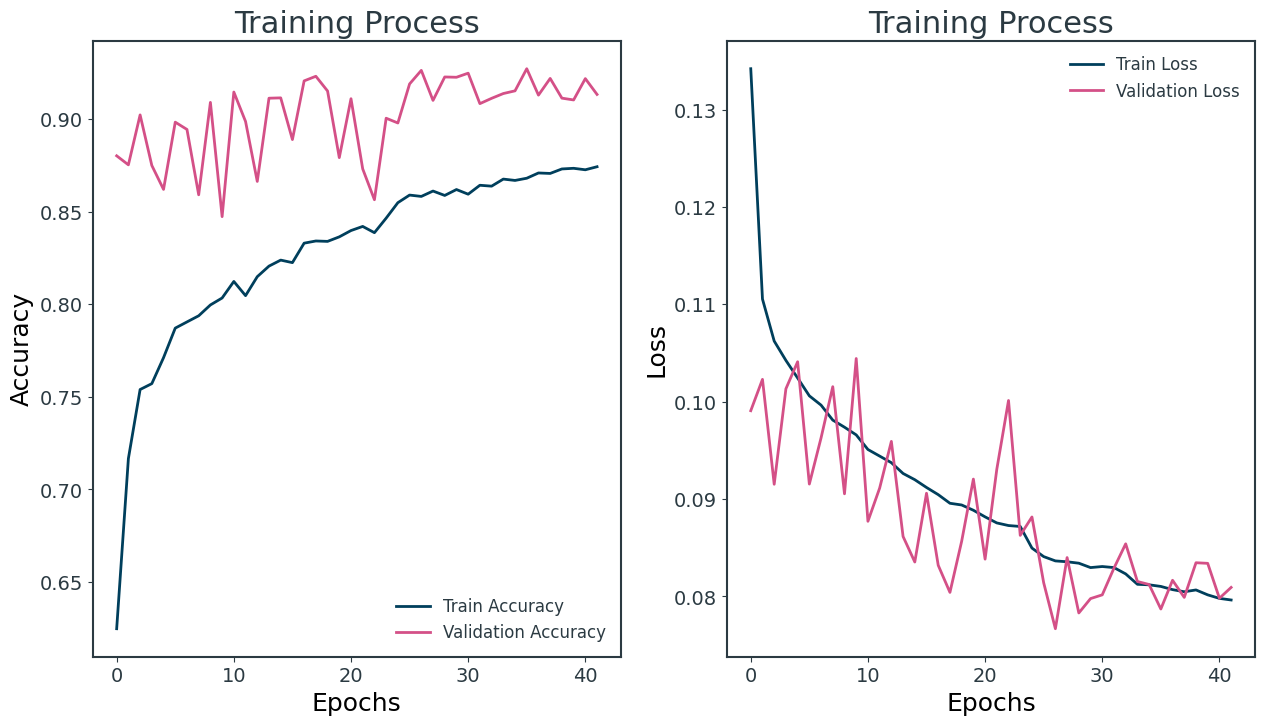

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [17]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.13419637084007263, 0.11053816974163055, 0.10622774064540863, 0.10423846542835236, 0.10243315249681473, 0.10060065984725952, 0.09964745491743088, 0.09810777753591537, 0.09737983345985413, 0.09659049659967422, 0.09509028494358063, 0.09441307932138443, 0.09373608231544495, 0.09262843430042267, 0.09198840707540512, 0.09119028598070145, 0.09045367687940598, 0.0895674005150795, 0.08939161896705627, 0.08885175734758377, 0.08817046135663986, 0.08754896372556686, 0.08728036284446716, 0.0871848613023758, 0.08496622741222382, 0.08409078419208527, 0.08364815264940262, 0.08355958014726639, 0.08341298997402191, 0.08296284079551697, 0.08307160437107086, 0.08296270668506622, 0.08231360465288162, 0.08124591410160065, 0.0811937153339386, 0.08102758973836899, 0.08069852739572525, 0.08048050850629807, 0.08066505193710327, 0.08016233891248703, 0.07980026304721832, 0.07963450998067856]
[0.09907485544681549, 0.10229316353797913, 0.091

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")




16729/16729 [==============================] - 97s 6ms/step
R2 Score: 0.9307803308458225
MAE: 0.0766836051101392
